# Identify SS using PARSIM-K


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sippy_unipi import SS_Model, system_identification
from sippy_unipi import functionset as fset
from sippy_unipi import functionsetSIM as fsetSIM
#from sippy_unipi._typing import SSMethods

import src.models as models
import src.helper as helper


Models imported succesfully
Helper imported succesfully


In [2]:

# np.random.seed(0)
# # Example to test SS-methods

# # sample time
# ts = 1.0

# # SISO SS system (n = 2)
# A = np.array([[0.89, 0.0], [0.0, 0.45]])
# B = np.array([[0.3], [2.5]])
# C = np.array([[0.7, 1.0]])
# D = np.array([[0.0]])

# tfin = 500
# npts = int(tfin // ts) + 1
# Time = np.linspace(0, tfin, npts)

# # Input sequence
# U = np.zeros((1, npts))
# [U[0], _, _] = fset.GBN_seq(npts, 0.05)

# # Output
# x, yout = fsetSIM.SS_lsim_process_form(A, B, C, D, U)

# # measurement noise
# noise = fset.white_noise_var(npts, [0.15])

# # Output with noise
# y_tot = yout + noise

# # Plotting
# # fig, axs = plt.subplots(3, 1, sharex=True)
# # axs[0].plot(Time, U[0])
# # axs[0].set_ylabel("input")
# # axs[0].grid()
# # axs[0].set_xlabel("Time")
# # fig.savefig(output_dir + "/input.png")

# # axs[1].plot(Time, y_tot[0])
# # axs[1].set_ylabel("y_tot")
# # axs[1].grid()
# # axs[1].set_xlabel("Time")
# # axs[1].set_title("Ytot")
# # fig.savefig(output_dir + "/ytot.png")

# # System identification
# METHOD: list[SSMethods] = [
#     "CVA",
#     "MOESP",
#     "N4SID",
#     "PARSIM_K",
#     "PARSIM_P",
#     "PARSIM_S",
# ]
# legend = ["System"]

# # axs[2].plot(Time, y_tot[0], label="System")
# for method in METHOD:
#     sys_id = system_identification(y_tot, U, method, 2, SS_threshold=0.1)
#     if not isinstance(sys_id, SS_Model):
#         raise ValueError("SS model not returned")
#     xid, yid = fsetSIM.SS_lsim_process_form(
#         sys_id.A, sys_id.B, sys_id.C, sys_id.D, U, sys_id.x0
#     )
# #     axs[2].plot(Time, yid[0], label=method)
# # axs[2].legend()
# # fig.savefig(output_dir + "/result.png")

# plt.close("all")


In [3]:
A1 = 1
A2 = 0.5
k1 = 0.5
k2 = 0.8

TwoTanks = models.TwoTanks(True, A1, A2, k1, k2)

In [4]:
# example simulation
sim_time = 500
Ts = 1
h1 = 1
h2 = 0.5
h0 = [h1, h2]
u = np.ones((sim_time,2))*0.5


sim = TwoTanks.simulate(h0, u, Ts)

In [5]:
constrains = np.array([[0, 0.5], [0, 1]])
step_time = 100
no_steps = 100
steps = helper.generate_steps(step_time, no_steps, constrains)

In [6]:
Ts = 1
h1 = 1
h2 = 0.5
u1 = steps[0,:]
u2 = steps[1,:]

sim = TwoTanks.simulate([h1, h2], steps, Ts)

In [7]:
# add noise to sim data
add_noise = True
if add_noise:
    # add noise to the simulation data
    # set random seed for reproducibility
    np.random.seed(42)
    noise = np.random.normal(0, 0.1, sim["Y"].shape)
    sim["Y"] += noise

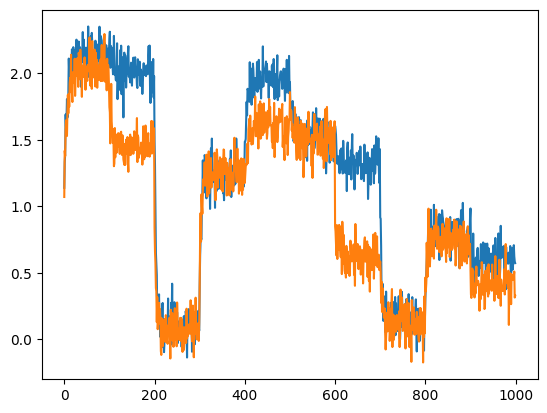

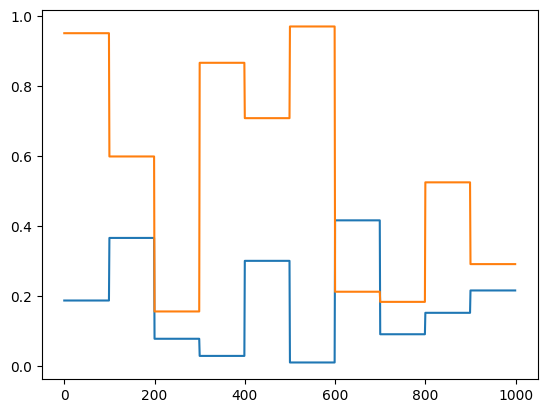

In [8]:
part = 1000
plt.plot(sim["Y"][:part])

plt.figure()
plt.plot(sim["U"][:part])

In [9]:
train_sim = {key: value[:5000] for key, value in sim.items()}
test_sim = {key: value[7000:] for key, value in sim.items()}
dev_sim = {key: value[5000:7000] for key, value in sim.items()}

In [10]:
y_tot = train_sim["Y"]
U = train_sim["U"].T

In [27]:

sys_id = system_identification(y_tot.copy(), U.copy(), "PARSIM_K", 10)
if not isinstance(sys_id, SS_Model):
    raise ValueError("SS model not returned")

In [29]:
sys_id.A, sys_id.B, sys_id.C, sys_id.D

(array([[ 0.95890718,  0.11282738,  0.02476443],
        [ 0.06851777,  0.7948351 , -0.04745565],
        [ 0.01974349, -0.04001888,  0.99213216]]),
 array([[-0.15920809, -0.10693223],
        [ 0.28724388,  0.19510047],
        [ 0.05647717,  0.03885105]]),
 array([[-3.19739821,  1.43016511, -0.44803024],
        [-2.536277  ,  0.35723862,  0.62293336]]),
 array([[0., 0.],
        [0., 0.]]))

In [13]:
np.linalg.pinv(sys_id.C)@test_sim["Y"][0].reshape(-1, 1)

array([[-0.52356804],
       [ 0.35093192],
       [-0.22031808]])

In [14]:
sys_id.x0

array([[-0.19436883],
       [ 0.51887703],
       [ 0.85768343]])

In [15]:
xid, yid = fsetSIM.SS_lsim_process_form(
        sys_id.A, sys_id.B, sys_id.C, sys_id.D, test_sim["U"].T, np.linalg.pinv(sys_id.C)@test_sim["Y"][0].reshape(-1, 1)
    )

In [16]:
yid.shape

(2, 3000)

In [17]:
#     "CVA", - same
#     "MOESP", - same
#     "N4SID", - same
#     "PARSIM_K",
#     "PARSIM_P",
#     "PARSIM_S",

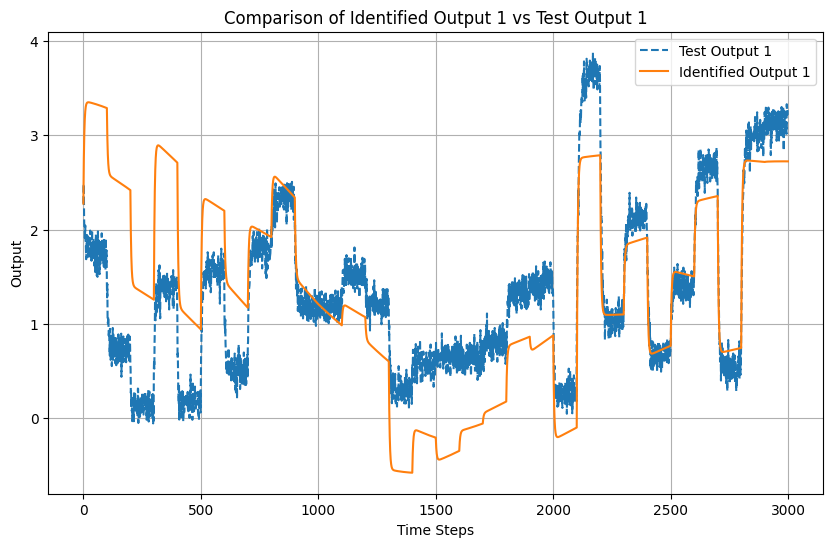

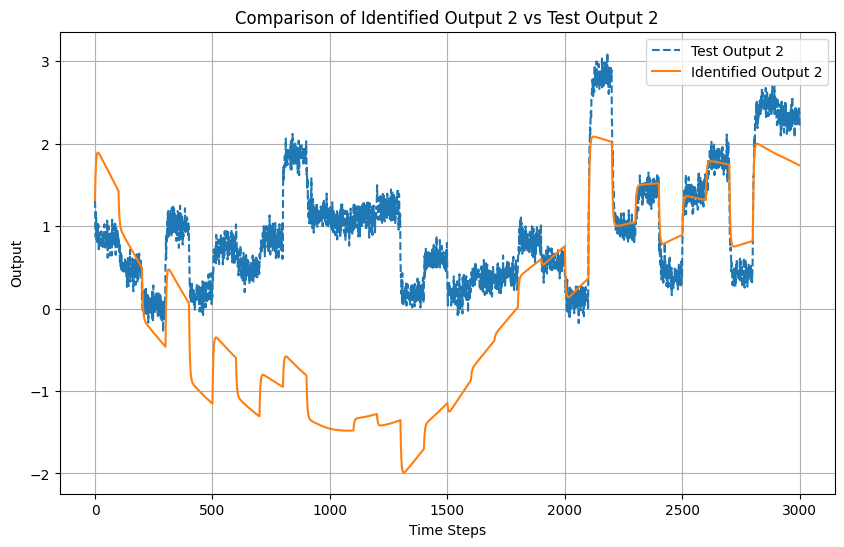

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(test_sim["Y"][:, 0], label="Test Output 1", linestyle="--")
plt.plot(yid[0, :], label="Identified Output 1")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.title("Comparison of Identified Output 1 vs Test Output 1")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(test_sim["Y"][:, 1], label="Test Output 2", linestyle="--")
plt.plot(yid[1, :], label="Identified Output 2")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.title("Comparison of Identified Output 2 vs Test Output 2")
plt.legend()
plt.grid()
plt.show()

In [19]:
xid, yid = fsetSIM.SS_lsim_process_form(
        sys_id.A, sys_id.B, sys_id.C, sys_id.D, train_sim["U"].T, np.linalg.pinv(sys_id.C)@train_sim["Y"][0].reshape(-1, 1)#sys_id.x0
    )

In [20]:
train_sim["U"].T

array([[0.18727006, 0.18727006, 0.18727006, ..., 0.01270956, 0.01270956,
        0.01270956],
       [0.95071431, 0.95071431, 0.95071431, ..., 0.10789143, 0.10789143,
        0.10789143]], shape=(2, 5000))

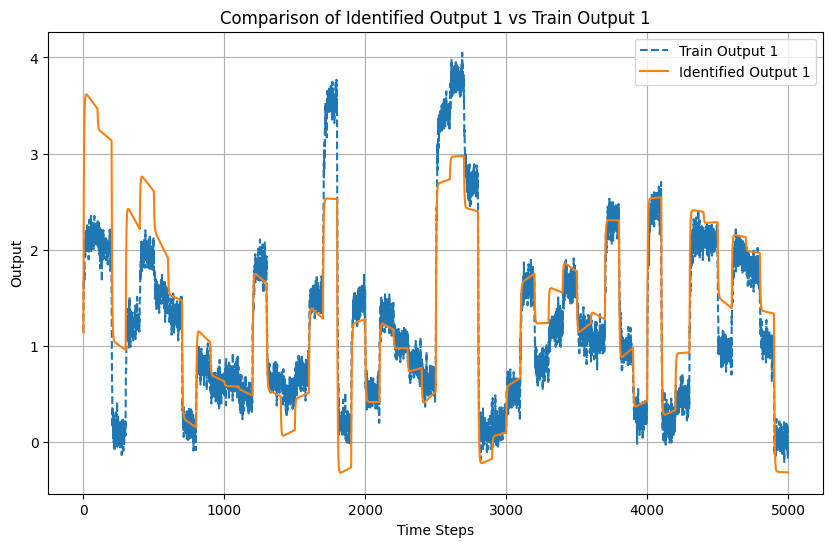

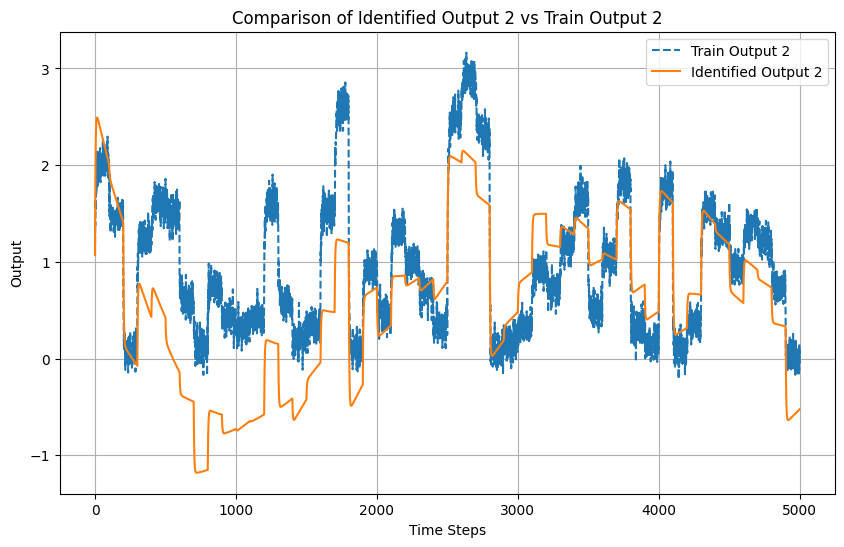

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(train_sim["Y"][:, 0], label="Train Output 1", linestyle="--")
plt.plot(yid[0, :], label="Identified Output 1")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.title("Comparison of Identified Output 1 vs Train Output 1")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_sim["Y"][:, 1], label="Train Output 2", linestyle="--")
plt.plot(yid[1, :], label="Identified Output 2")
plt.xlabel("Time Steps")
plt.ylabel("Output")
plt.title("Comparison of Identified Output 2 vs Train Output 2")
plt.legend()
plt.grid()
plt.show()